# MAC0219 - Programação Concorrente, Paralela e Distribuída
# EP2: CUDA & OpenMPI


| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

Neste relatório, temos como objetivo explicar como foram feitas as nossas implementações do cálculo do Conjunto de Mandelbrot para as diferentes metodologias de paralelização, explicar como foram realizados os experimentos com essas implementações e analisarmos os resultados obtidos. 

Os arquivos-fonte de todas as implementações foram fornecidos junto a este relatório, bem como o arquivo makefile que possibilita todas as compilações. Além disso, fornecemos ainda um script em Pyhton ( `run_experiments.py` ) que, quando executado, realiza uma rodada de experimentos para todas as versões por nós implementadas seguindo as configurações indicadas no enunciado: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**. Tal script gera, ao final, arquivos .csv com os resultados dos experimentos. 

Durante este relatório, utilizamos as duas funções abaixo para importar e processar as informações dos arquivoc csv que obtimos com os nossos experimentos, executados na Rede Linux. Todos estes arquivos foram também fornecidos. 

In [53]:
using DataFrames, Query, StatsPlots, Statistics, CSV, Plots

In [54]:
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

# 1. Implementação em CUDA

A implementação em CUDA foi feita tendo como base a versão sequencial, a qual adaptamos para as necessidades da paralelização com computação heterogênea, como é o caso aqui. Nesse sentido, transformamos o método `void compute_mandelbrot()` num método global, pois é este o **Kernel** do programa - isto é, a função que conecta o _Host_ (CPU) com o _Device_ (GPU). Além disso, deixamos os métodos que são utilizados somente durante o processamento dos pixels (à saber, `int mandelbrot()` e `void update_rgb_buffer()`) como exclusivas para o _device_. O restante das conexões entre as duas camadas de memória, _Host_ e _Device_ , foi feito manipulando adequadamente a alocação e tráfego de memória quando e onde necessário. 

A divisão de tarefas é feita de maneira estática à partir das dimensões dos _Blocos_ e do _Grid_ no qual estes estão inseridos. Para que pudessemos determinar experimentalmente os melhores valores para essas dimensões, o programa solicita como argumento (além das coordenadas da região do conjunto e o tamanho da imagem) as dimensões $(x, y)$ dos blocos. À partir desses valores, determina-se também as dimensões do _Grid_ de forma a garantir que a divisão das tarefas contemple toda a imagem a ser gerada. No caso da nossa implementação, isso significa atribuir ao _Grid_ dimensões $(\frac{image\_size}{x}, \frac{image\_size}{y})$. 

Dessa forma, fica estabelecido que cada pixel $(i_x, i_y)$ da imagem será tratado por uma _thread_ de identidade determinada pela sua posição num determinado bloco do grid de acordo com as especificações abaixo:

$$
i_x = blockIdx.x*blockDim.x+threadIdx.x \\
i_y = blockIdx.y*blockDim.y+threadIdx.y
$$

É importante observar uma condição de execução crucial relativa a essa implementação: devemos ter, necessariamente, $x * y \leq 1024$. Isso pois ao determinarmos as dimensões dos blocos como sendo $(x, y)$, isso significa que a quantidade de _threads_ em cada bloco é igual a $x * y$. O limite de $1024$ _threads_ por bloco é uma condição própria do desenvolvimento em CUDA.

## 1.1 Experimentos com CUDA

O objetivo aqui é realizar experimentos para diferentes valores dos parâmetros $x$ e $y$, que determinam a dimensão dos blocos e, por conseguinte, do _grid_. Para tanto, determinamos uma região de interesse para esses parâmetros cujo principal critério de escolha foi garantir que mantivéssemos $x * y \leq 1024$, conforme explicado anteriormente. Nesse sentido, decidimos começar com blocos de dimensao $(2,2)$ --- isto é, quatro threads por bloco, implicando num grid de dimensão $(\frac{image\_size}{2}, \frac{image\_size}{2}) = (\frac{4096}{2}, \frac{4096}{2}$) --- e irmos dobrando até $(32, 32)$, onde têm-se em cada bloco o limite de $1024$ threads, com _grid_ de dimensão $(128, 128)$. 

A **região de interesse** final, com a qual realizamos os experimentos, é:

**Dimensões dos blocos:** $(2,2)$, $(4,4)$, $(8,8)$, $(16,16)$ e $(32,32)$ 

**Respectivas dimensoes do _grid_ :** $(2048, 2048)$, $(1024, 1024)$, $(512, 512)$, $(256, 256)$ e $(128, 128)$ 

Os resultados dos experimentos estão no arquivo _cuda_experiments.csv_ , que importamos abaixo:

In [55]:
experiments_cuda = read_csv_results("cuda_experiments.csv")

,dimensions,duration
,String,Float64
1,"2, 2",18.4867
2,"2, 2",17.6385
3,"2, 2",17.6688
4,"2, 2",17.6069
5,"2, 2",17.6232
6,"2, 2",17.6025
7,"2, 2",17.606
8,"2, 2",17.7131
9,"2, 2",17.7515


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse, conforme abaixo:

In [56]:
final_results_cuda = experiments_cuda |>
                    @groupby({_.dimensions,}) |>
                    @map({dimensions = key(_).dimensions,
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>                    
                    DataFrame

,dimensions,mean_duration,ci_duration
,String,Float64,Float64
1,"2, 2",17.6899,0.440795
2,"4, 4",4.52136,0.356347
3,"8, 8",2.27246,0.0727005
4,"16, 16",2.28517,0.144487
5,"32, 32",2.27029,0.0068397


# 2. Implementação em OMPI

A implementação em OMPI também teve como base a implementação sequencial do programa, que foi adequada para a paralelização através da troca de mensagens. Para este fim, a função `compute_mandelbrot` foi adaptada para receber parâmetros adicionais e uma função responsável por gerenciar a troca de mensagens - `compute_mandelbrot_ompi`- foi criada. Iremos explicar a implementação descrevendo o que é feito pelo processo principal (de rank 0, também chamado de `MASTER` no código) e pelos processos auxiliares.

**Processo Principal:**

No processo principal, primeiramente são inicializadas várias variáveis globais e os tipos de dados a serem utilizados pelas mensagens são definidos. Logo a seguir, o processo realiza a inicialização e os cálculos dos parametros a serem passados a cada outro processo para definir em que região da imagem ele irá trabalhar. 

A imagem é dividida em retângulos de largura `image_size` - que nos nossos experimentos é `4096` - e altura $\frac{image\_size}{num\_processes}$. Ou seja, a divisão de trabalho entre processes é igualitária em tamanho de entrada e cada um dos processos envolvidos - inclusive o processo master - processa um retângulo.

O processo principal então manda mensagens para todos os processos auxiliares com os valores que definem as coordenadas de começo e término da região que cada um deverá processar. Em seguida ele espera os processos terminarem a computação. Ao receber o resultado dos processos auxiliares, o processo master realiza a sua porção da computação de mandelbrot.


O processo principal então recebe um vetor 1D com os valores de $x$,$y$ e $iterations$ para cada pixel, e uma variável `count` indicando o tamanho desse vetor. Depois de receber os resultados de todos processos o processo principal transfere os valores para a imagem determinado as cores correspondentes.

**Processos Auxiliares**

Os processos auxiliares realizam o mesmo processo de inicialização das variáveis globais e dos tipos de dados. Depois disso esperam, através da chamada `MPI_Recv` uma mensagem do processo principal definindo a sua região da imagem.


Assim, definimos que todos processos devem processar a região de mandelbrot igualmente, no entando, existe um processo `MASTER` que além de processar a região também define a quantidade de trabalho que cada processo deverá ficar responsável e realiza o envio dessa informação para cada processo.Além disso, ele também recebe o resultado dos processos auxiliares e, junto dos valores calculados pelo próprio processo master, monta a imagem resultante.

## 2.1 Experimentos com OMPI

O objetivo é determinar um número ideal $n$ de processos para a implementação através desses experimentos. Definimos a região de interesse conforme sugestão do enunciado, mas sempre tendo pelo menos um processo principal que coletasse os resultados, sendo assim a **região de interesse** com que realizamos os experimentos foi:


**Número de Processos:** $2$, $3$, $5$, $9$, $17$, $33$, $65$

Os resultados dos experimentos estão no arquivo _ompi_experiments.csv_ , que importamos abaixo:

In [57]:
experiments_ompi = read_csv_results("ompi_experiments.csv")

,processes,duration
,Int64,Float64
1,1,28.0747
2,1,27.9121
3,1,28.0582
4,1,27.9146
5,1,27.9695
6,1,28.1327
7,1,28.1941
8,1,28.6664
9,1,28.1974


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse, conforme abaixo:

In [58]:
final_results_ompi =  experiments_ompi |>
                        @groupby({_.processes,}) |>
                        @map({processes = string((key(_).processes)),
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame

,processes,mean_duration,ci_duration
,String,Float64,Float64
1,1,28.0701,0.376175
2,2,28.088,0.3028
3,4,16.1945,0.247247
4,8,9.8104,0.45482
5,16,6.3391,0.219758
6,32,5.38814,0.405501
7,64,4.78659,0.268464


# 3. Implementação em OMPI + OMP

Nessa implementação, mantivemos a estrutura de comunicação definida na implementação com OMP e alteramos como cada processo processa sua região da imagem: para calcular o número de iterações até a convergência de cada pixel, paralelizamos a computação por OpenMP. Para tanto, as mudanças ocorreram apenas na função `compute_mandelbrot`.


## 3.1 Experimentos com OMPI + OMP

Seguindo as instruções do enunciado, os experimentos foram feitos usando os seguintes parâmetros fixos: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**.

Os números de processos foram determinados da mesma maneira que na implementação em OMPI, para fins de equivalência dos experimentos. O número $t$ de threads varia entre 1 e 64 seguindo as potências de 2, afim de cobrir uma região grande, permitindo analisar o impacto desse parâmetro. Consideramos que valores maiores gerariam um overhead muito grande, tornando o experimento pouco informativo.


**Número de Processos:** $2$,$3$,$5$,$9$,$17$,$33$,$65$

**Número de Threads:** $1$,$2$,$4$,$8$,$16$,$32$,$64$

Os resultados dos experimentos estão no arquivo _ompi_omp_experiments.csv_ , que importamos abaixo:

In [59]:
experiments_ompi_omp = read_csv_results("ompi_omp_experiments.csv")

,processes,threads,duration
,Int64,Int64,Float64
1,2,1,27.6118
2,2,1,27.5035
3,2,1,27.4721
4,2,1,27.4793
5,2,1,27.4822
6,2,1,27.478
7,2,1,27.4936
8,2,1,27.4745
9,2,1,27.4947


Com estes resultados, podemos obter o tempo médio de execução e os respectivos intervalos de confiança para cada parâmetro da nossa região de interesse. Dessa vez...

In [60]:
final_results_ompi_omp = experiments_ompi_omp |>
                        @groupby({_.threads,_.processes}) |>
                        @map({threads = key(_).threads,
                              processes = string(key(_).processes),
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame

,threads,processes,mean_duration,ci_duration
,Int64,String,Float64,Float64
1,1,2,27.5003,0.0695838
2,2,2,16.091,0.342864
3,4,2,16.7103,0.244579
4,8,2,16.9672,0.0585683
5,16,2,17.1328,0.0579415
6,32,2,17.2445,0.0602369
7,64,2,17.2545,0.0497869
8,1,3,19.5736,0.0855659
9,2,3,11.371,0.0451151


# 4. Implementação em OMPI + CUDA

Nessa implementação, mantivemos a estrutura de comunicação definida na implementação com OMPI e alteramos como cada processo auxiliar processa sua região da imagem: realizamos o cálculo do número de iterações até a convergência de cada pixel na GPU através do `cuda`.

## 4.1 Experimentos com OMPI + CUDA

A região de interesse foi determinada de maneira a manter a consistência experimental entre as diferentes implementações. Sendo assim:

**Número de Processos:** $2$,$3$,$5$,$9$,$17$,$33$,$65$

**Dimensões dos blocos:** $(2,2)$, $(4,4)$, $(8,8)$, $(16,16)$ e $(32,32)$ 

Os resultados dos experimentos estão no arquivo _ompi_omp_experiments.csv_ , que importamos abaixo:

In [61]:
experiments_ompi_cuda = read_csv_results("ompi_cuda_experiments.csv")

,processes,dimensions,duration
,Int64,String,Float64
1,2,"2, 2",4.74935
2,2,"2, 2",4.0107
3,2,"2, 2",4.41688
4,2,"2, 2",3.98594
5,2,"2, 2",4.69576
6,2,"2, 2",3.50715
7,2,"2, 2",4.98862
8,2,"2, 2",4.12465
9,2,"2, 2",3.94018


In [62]:
final_results_ompi_cuda = experiments_ompi_cuda|>
                    @groupby({_.dimensions,_.processes}) |>
                        @map({dimensions = key(_).dimensions,
                              processes = string(key(_).processes),
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame

,dimensions,processes,mean_duration,ci_duration
,String,String,Float64,Float64
1,"2, 2",2,4.17259,0.929573
2,"4, 4",2,3.50126,1.84226
3,"8, 8",2,3.01322,0.565195
4,"16, 16",2,3.56778,0.794565
5,"32, 32",2,4.32816,1.32265
6,"2, 2",3,5.46269,1.55897
7,"4, 4",3,5.87547,3.06311
8,"8, 8",3,2.95505,0.68763
9,"16, 16",3,2.59008,0.232956


# 5. Análise dos resultados dos experimentos

Faremos uso das duas funções abaixo para gerar os gráficos sobre os quais analisaremos cada caso:

In [63]:
#Labels para os gráficos
threads = [1 2 4 8 16 32 64]
processes =[2 3 5 9 17 33 65]
dimensions = ["(2,2)" "(4,4)" "(8,8)" "(16,16)" "(32,32)"]

1×5 Array{String,2}:
 "(2,2)"  "(4,4)"  "(8,8)"  "(16,16)"  "(32,32)"

In [64]:
function plot_results(x, y1, series_label, xlabel_, ylabel_, title_, yerror)
    if yerror == []
        p = scatter(x, y1,
        alpha = 0.6,
        labels = series_label,
        xlabel = xlabel_,
        ylabel = ylabel_,
        title = title_,
        legend = :topright)

        return p  
    end
    
    p = plot(x,        
            y1,
            yerror = yerror,
            alpha = 0.9,
            labels = series_label,
            xlabel = xlabel_,
            ylabel = ylabel_,
            title = title_,
            color = "red",
            seriestype = :scatter,
            lw = 1,
            legend = :topright)
    
    return p   
end

plot_results (generic function with 1 method)

## 5.1 Resultados da versão CUDA

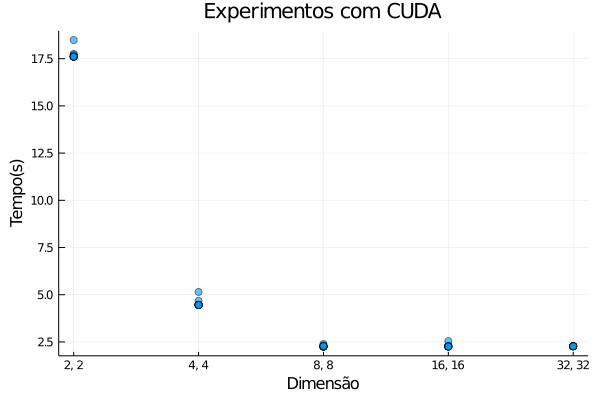

In [65]:
plot_results(experiments_cuda.dimensions, experiments_cuda.duration, "", "Dimensão", "Tempo(s)", "Experimentos com CUDA", [])

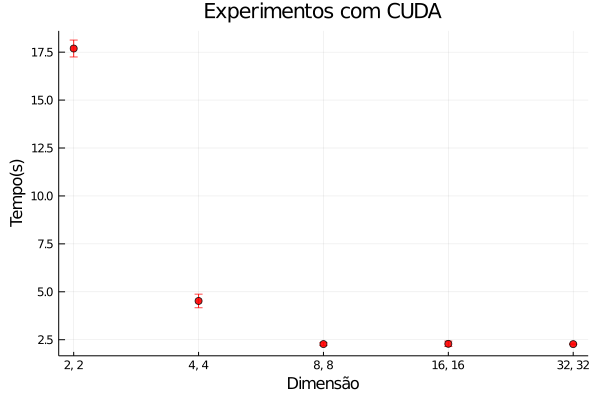

In [66]:
plot_results(final_results_cuda.dimensions,
    final_results_cuda.mean_duration,    
    "", "Dimensão", "Tempo(s)", "Experimentos com CUDA", 
    final_results_cuda.ci_duration)

**Análise e escolha de melhores parâmetros:**

No primeiro gráfico, vemos que para experimentos com blocos de dimensão $(2, 2)$ e $(4, 4)$ há uma variação maior dos tempos de execução individual dentre as $15$ feitas em cada caso, o que, portanto, se reflete na maior amplitude dos respectivos intervalos de confiança em comparação com as dimensões de ordem superior, como fica evidente no segundo gráfico. 
Além disso, nota-se que conforme aumenta-se a dimensão dos blocos menor é o impacto em tempo de execução ao dobrar a dimensão do bloco, inclusive, é praticamente nula a partir de blocos de tamanho (8,8). 

Observamos, por exemplo, que para blocos de dimensão $(2,2)$ e $(4,4)$, a diferença de tempo médio de execução é notável ao dobrar o tamanho do bloco no experimento: aproximadamente 17.5 segundos se dobrarmos de $(2,2)$ para $(4,4)$ e menos de 5s se dobrarmos de $(4,4)$ para $(8,8)$. Para acréscimos acima disso, a diferença de tempo é imperceptível pelo gráfico.

Posto isso, os dados dos experimentos nos permitem concluir com segurança que, para as condições de hardware em questão, execuções com blocos de dimensão $(8,8)$, e portanto em _grid_ de dimensão $(\frac{image\_size}{8}, \frac{image\_size}{8}) = (512, 512)$, são a melhor escolha dentro da região de interesse na qual os experimentos foram feitos. Isto pois o resultado dos experimentos mostram que o desempenho com tal dimensão é tão bom quanto com dimensões maiores e, sendo assim, faz sentido optar por permanecer com a necessidade de gerenciamente de um menor número de threads por bloco. 

## 5.2 Resultados da versão OMPI

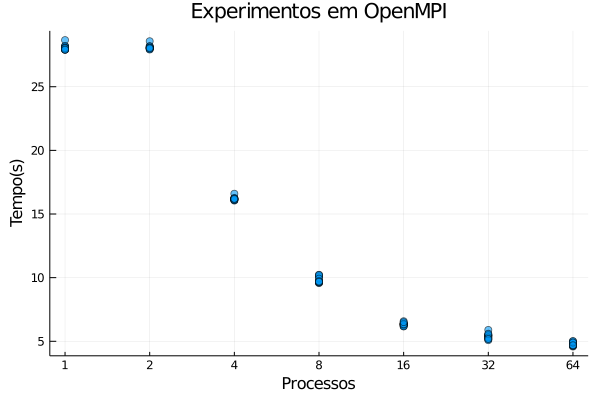

In [67]:
#plotar graficos com todos os pontos
experiments_ompi[! , :processes_string] = [string(x) for x in experiments_ompi[!, :processes]]
plot_results(experiments_ompi.processes_string, experiments_ompi.duration, 
    "", "Processos", "Tempo(s)", "Experimentos em OpenMPI", [])

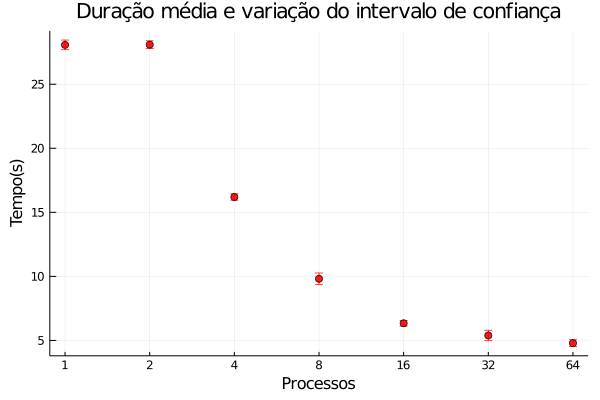

In [68]:
#plotar graficos com tempo medio e intervalo de confiança
plot_results(final_results_ompi.processes,
    final_results_ompi.mean_duration,    
    "", "Processos", "Tempo(s)", "Duração média e variação do intervalo de confiança", 
    final_results_ompi.ci_duration)

**Análise e escolha de melhores parâmetros:**

Podemos observar que, à partir de dois processos, o tempo médio de execução consistentemente diminui conforme aumenta a quantidade de processos envolvidos, e a partir de $16$ processos os ganhos em tempo de execução passam a ser marginais relativamente as diminuições anteriores. 

Vale chamar atenção para o fato de que os dados obtidos para os experimentos com $1$ e $2$ processos foram muito próximos, com valores médios para os tempos de execução e respectivos intervalos de confiança bastante similares. Buscando entender a causa para tal resultado, entendemos que tal similaridade se deve ao fato de que com $1$ processo não há distribuição de tarefa (há simplemente o processamento total da imagem), e com $2$ processos o primeiro processo tem um _overhead_ de gerenciamento de mensagens e distribuição de tarefas (além de processar parte da imagem). A partir de $4$ processos a divisão de trabalho vence o _overhead_ de gerenciamento.

Os gráficos permitem observar ainda que o tempo individual de cada execução para uma determinada quantidade de processos se mostrou em geral consistente em todos os casos, isto é, constata-se pouca variação no tempo individual de cada umas das $15$ execuções, levanto a valores para os respectivos tempos médio de execução com intervalos de confiança com amplitudes muito pequenas. 

Como o tempo de execução diminui consistentemente e o intervalo de confiança é pequeno, comparativamente concluimos que o desempenho é ótimo para **64 processos**.

## 5.3 Resultados da versão OMPI + OMP


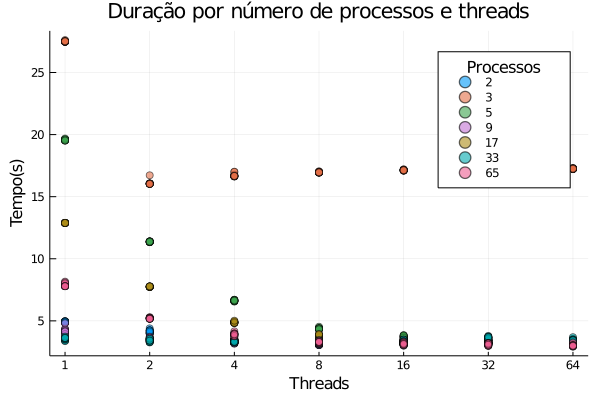

In [69]:
experiments_ompi_omp[! , :threads_string] = [string(x) for x in experiments_ompi_omp[!, :threads]]
experiments_ompi_omp[! , :processes_string] = [string(x) for x in experiments_ompi_omp[!, :processes]]
p = scatter(
        experiments_ompi_omp.threads_string, 
        experiments_ompi_omp.duration,
        title = "Duração por número de processos e threads",
        xlabel = "Threads",
        legendtitle = "Processos",
        ylabel = "Tempo(s)",
        labels = processes,
        alpha = 0.6,
        group = experiments_ompi_omp.processes_string,
        legend = :topright)

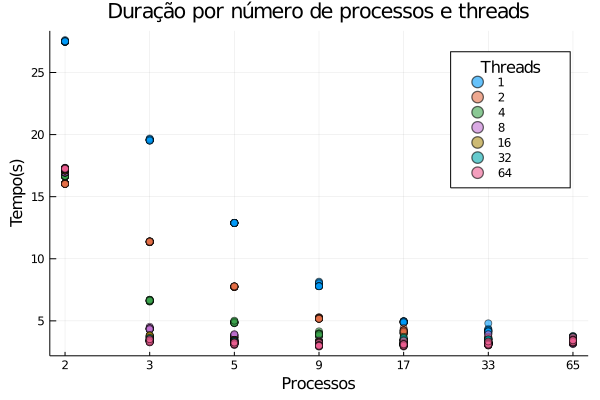

In [70]:
p = scatter(
        experiments_ompi_omp.processes_string, 
        experiments_ompi_omp.duration,
        title = "Duração por número de processos e threads",
        xlabel = "Processos",
        legendtitle = "Threads",
        ylabel = "Tempo(s)",
        labels = threads,
        alpha = 0.6,
        group = experiments_ompi_omp.threads,
        legend = :topright)

In [71]:
final_results_ompi_omp[! , :processes_string] = [string(x) for x in final_results_ompi_omp[!, :processes]]
final_results_ompi_omp[! , :threads_string] = [string(x) for x in final_results_ompi_omp[!, :threads]]

fr_ompi_omp_with_64_processes = final_results_ompi_omp[(final_results_ompi_omp[:processes].=="65"),:]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[71]:3
└ @ Core In[71]:3


,threads,processes,mean_duration,ci_duration,processes_string,threads_string
,Int64,String,Float64,Float64,String,String
1,1,65,3.55358,0.202285,65,1
2,2,65,3.40062,0.178076,65,2
3,4,65,3.33918,0.110103,65,4
4,8,65,3.27033,0.188005,65,8
5,16,65,3.35709,0.129938,65,16
6,32,65,3.65743,0.146257,65,32
7,64,65,3.41318,0.236205,65,64


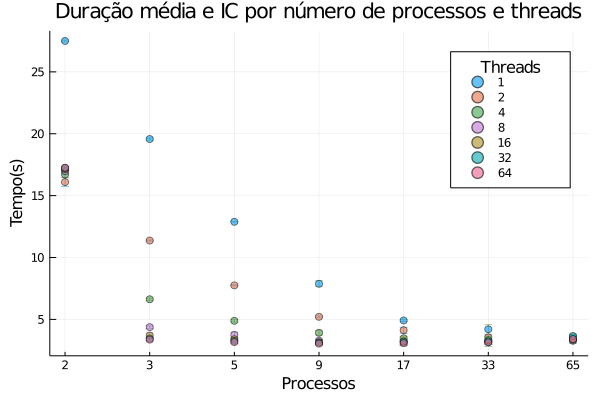

In [72]:
p = scatter(
        final_results_ompi_omp.processes_string, 
        final_results_ompi_omp.mean_duration,
        title = "Duração média e IC por número de processos e threads",
        xlabel = "Processos",
        legendtitle = "Threads",
        ylabel = "Tempo(s)",
        labels = threads,
        alpha = 0.6,
        yerror = final_results_ompi_omp.ci_duration,
        group = final_results_ompi_omp.threads,
        legend = :topright)

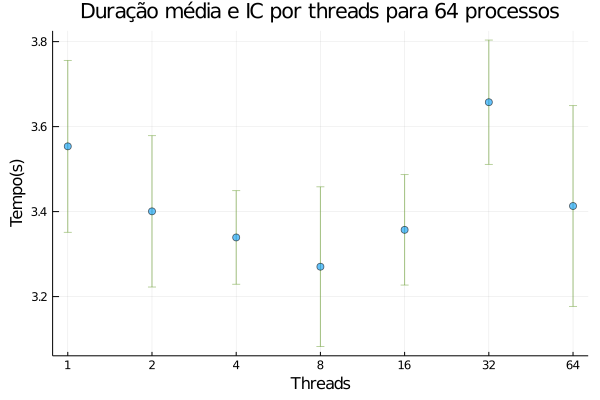

In [73]:
p = scatter(
        fr_ompi_omp_with_64_processes.threads_string, 
        fr_ompi_omp_with_64_processes.mean_duration,
        title = "Duração média e IC por threads para 64 processos",
        xlabel = "Threads",
        ylabel = "Tempo(s)",
        alpha = 0.6,
        yerror = fr_ompi_omp_with_64_processes.ci_duration,
        legend=false)

Baseado nos gráficos, podemos concluir que o tempo de execução médio decai consistemente com o aumento do número de processos lançados. Ademais, nota-se que o tempo de execução sofre uma influência maior do número de processos em relação ao número de threads. Percebemos que o tempo de execução é ótimo para 64 processos. Para decidir o número correspondente de threads, plotamos mais um gráfico fixando 64 processos e analisando a diferença no tempo de execução para diferentes threads e concluimos que o tempo de execução é ótimo para 8 threads.

## 5.4 Resultados da versão OMPI + CUDA


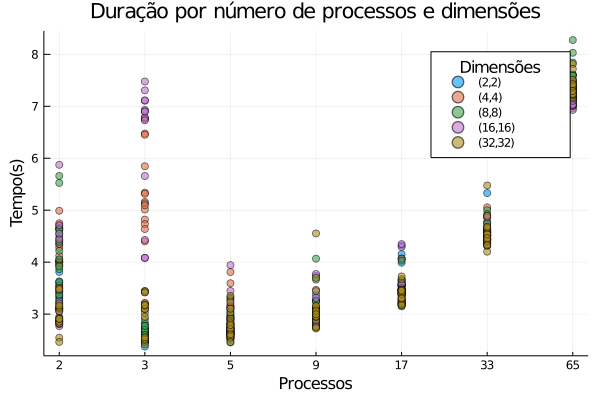

In [79]:
experiments_ompi_cuda[! , :processes_string] = [string(x) for x in experiments_ompi_cuda[!, :processes]]

p = scatter(
        experiments_ompi_cuda.processes_string, 
        experiments_ompi_cuda.duration,
        title = "Duração por número de processos e dimensões",
        xlabel = "Processos",
        legendtitle = "Dimensões",
        ylabel = "Tempo(s)",
        labels = dimensions,
        alpha = 0.6,
        group = experiments_ompi_cuda.dimensions,
        legend = :topright)

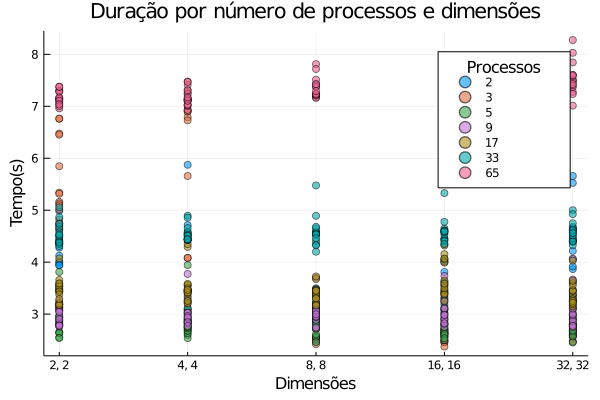

In [80]:
p = scatter(
        experiments_ompi_cuda.dimensions, 
        experiments_ompi_cuda.duration,
        title = "Duração por número de processos e dimensões",
        xlabel = "Dimensões",
        legendtitle = "Processos",
        ylabel = "Tempo(s)",
        labels = processes,
        alpha = 0.6,
        group = experiments_ompi_cuda.processes,
        legend = :topright)

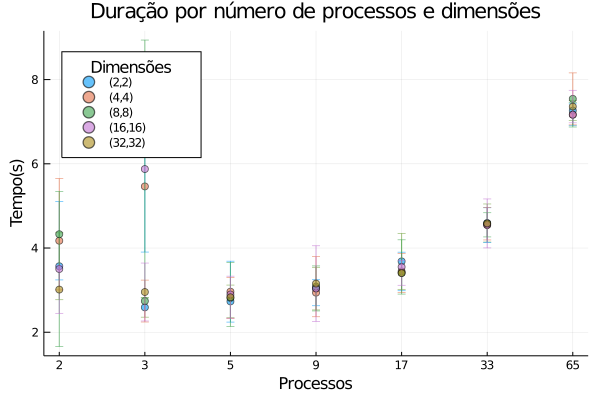

In [81]:
p = scatter(
        final_results_ompi_cuda.processes, 
        final_results_ompi_cuda.mean_duration,
        title = "Duração por número de processos e dimensões",
        xlabel = "Processos",
        legendtitle = "Dimensões",
        ylabel = "Tempo(s)",
        labels = dimensions,
        alpha = 0.6,
        group = final_results_ompi_cuda.dimensions,
        yerror = final_results_ompi_cuda.ci_duration,
        legend = :topleft)

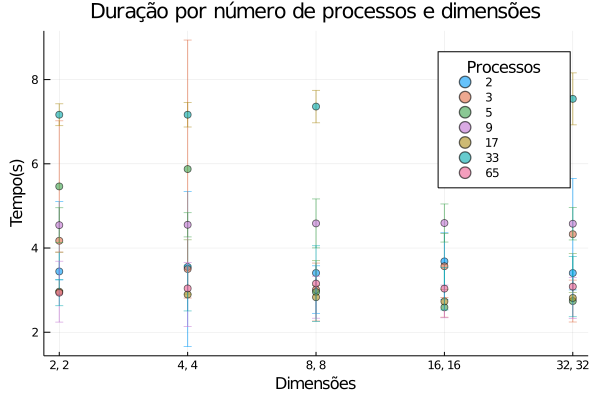

In [82]:
p = scatter(
        final_results_ompi_cuda.dimensions, 
        final_results_ompi_cuda.mean_duration,
        title = "Duração por número de processos e dimensões",
        xlabel = "Dimensões",
        legendtitle = "Processos",
        ylabel = "Tempo(s)",
        labels = processes,
        alpha = 0.6,
        group = final_results_ompi_cuda.processes,
        yerror = final_results_ompi_cuda.ci_duration,
        legend = :topright)

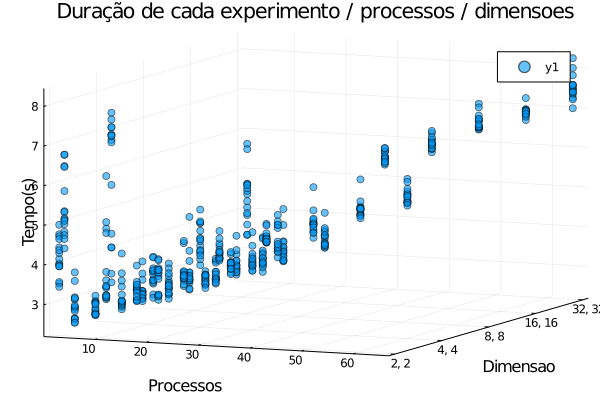

In [83]:
p = scatter3d(
        experiments_ompi_cuda.processes, 
        experiments_ompi_cuda.dimensions,
        experiments_ompi_cuda.duration,
        title = "Duração de cada experimento / processos / dimensoes",
        xlabel = "Processos",
        ylabel = "Dimensao",
        zlabel = "Tempo(s)",
        seriestype = :scatter,
        alpha = 0.6,
        legend = :topright
)

**ESCOLHER E JUSTIFICAR OS MELHORES PARAMETROS BASEANDO-SE NOS GRAFICOS!**



# 6. Resultados do EP1 seguindo o padrão do EP2

Para que possamos fazer uma analise comparativa entre todas as versões que desenvolvemos para o Cálculo do Conjunto de Mandelbrot, através do script _run_experiments.py_ executamos também experimentos relativos as versões entregues no EP1 (Sequencial, Pthreads e OpenMP) utilizando os mesmos parâmetros fixos considerados aqui: $15$ **repetições** da geração de uma imagem de **tamanho** $4096$ da região **Triple Spiral Valley**

Assim como nos casos anteriores, os arquivos .csv com os resultados destes experimentos foram fornecidos e nós os importamos abaixo:

### Sequencial:

In [84]:
experiments_sequencial = read_csv_results("seq_experiments.csv")

,duration
,Float64
1,27.5763
2,27.6554
3,28.2566
4,29.741
5,28.4806
6,29.4961
7,28.7576
8,28.2968
9,28.4506


In [85]:
final_results_sequencial = DataFrame(mean_duration = mean(experiments_sequencial.duration),
                              ci_duration = 1.96 * std(experiments_sequencial.duration))

,mean_duration,ci_duration
,Float64,Float64
1,28.4608,1.82404


### Pthreads:

A implementação utilizada foi a mesma feita no EP1, e os experimentos tiveram a seguinte região de interesse:

**Número de Threads:** $1$,$2$,$4$,$8$,$16$,$32$,$64$

Importamos os dados:

In [86]:
experiments_pth = read_csv_results("pth_experiments.csv")

,threads,duration
,Int64,Float64
1,1,28.8056
2,1,28.3448
3,1,29.0453
4,1,29.394
5,1,28.1015
6,1,28.3721
7,1,28.5022
8,1,28.2636
9,1,29.1992


In [87]:
final_results_pth = experiments_pth |>
                        @groupby({_.threads,}) |>
                        @map({threads = string(key(_).threads),
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame

,threads,mean_duration,ci_duration
,String,Float64,Float64
1,1,28.8472,1.19163
2,2,26.7858,0.543657
3,4,14.0143,0.79504
4,8,8.89757,0.616525
5,16,5.42304,0.579045
6,32,3.6455,0.463688
7,64,3.42551,0.548569


Temos então:

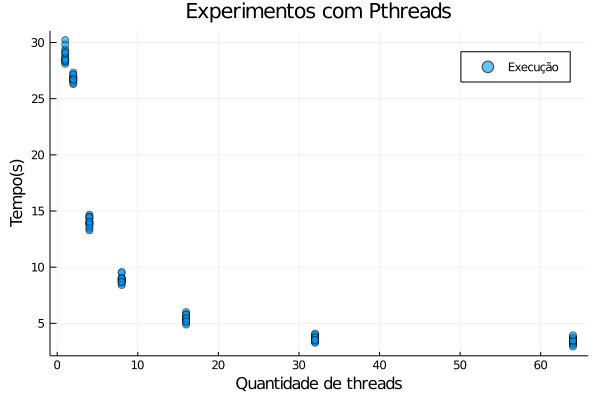

In [88]:
plot_results(experiments_pth.threads, experiments_pth.duration, 
    "Execução", "Quantidade de threads", "Tempo(s)", 
    "Experimentos com Pthreads", [])

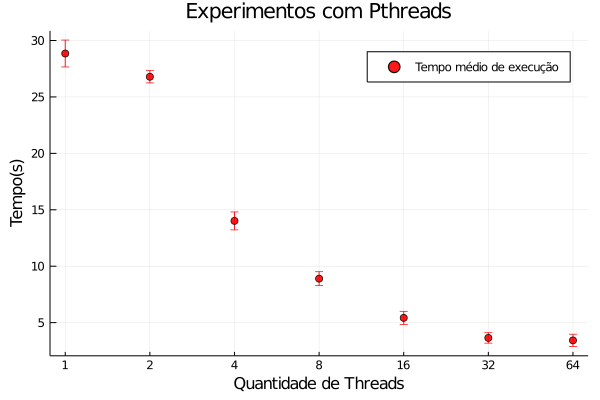

In [89]:
plot_results(final_results_pth.threads, final_results_pth.mean_duration, "Tempo médio de execução", "Quantidade de Threads", "Tempo(s)", "Experimentos com Pthreads", final_results_pth.ci_duration)

Podemos observar que ganhos significativos ocorrem até a marca de $32$ threads, e depois disso aparentemente o overhead se torna tão grande quanto os ganhos de performance. Ademais, na comparação entre $32$ e $64$ threads, notamos que com 32 threads o intervalo de confiança é menor e as médias são muito similares entre si. Portanto, definimos $32$ como o valor ideal deste parâmetro.

### OpenMP:

Os experimentos foram realizados da mesma maneira que na implementação em pthreads, e com a mesma região de interesse.

In [33]:
experiments_omp = read_csv_results("omp_experiments.csv")

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /Users/caioandrade/.julia/packages/CSV/W9RT2/src/CSV.jl:40


,threads,duration
,Int64,Float64
1,1,28.4714
2,1,29.1697
3,1,29.6925
4,1,28.6584
5,1,29.4521
6,1,28.7501
7,1,29.4946
8,1,28.8353
9,1,29.0405


In [34]:
final_results_omp = experiments_omp |>
                        @groupby({_.threads,}) |>
                        @map({threads = string(key(_).threads),
                              mean_duration = mean(_.duration),
                              ci_duration = 1.96 * std(_.duration)}) |>
                        DataFrame
   

,threads,mean_duration,ci_duration
,String,Float64,Float64
1,1,29.219,1.1909
2,2,14.7347,0.483159
3,4,8.56224,0.55287
4,8,5.55285,0.847721
5,16,4.11329,0.534923
6,32,3.25592,0.557335
7,64,3.24436,0.44773


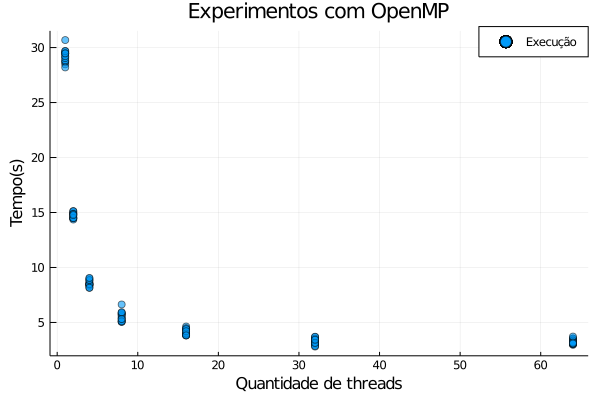

In [35]:
plot_results(experiments_omp.threads, experiments_omp.duration, "Execução", "Quantidade de threads", "Tempo(s)", "Experimentos com OpenMP", [])

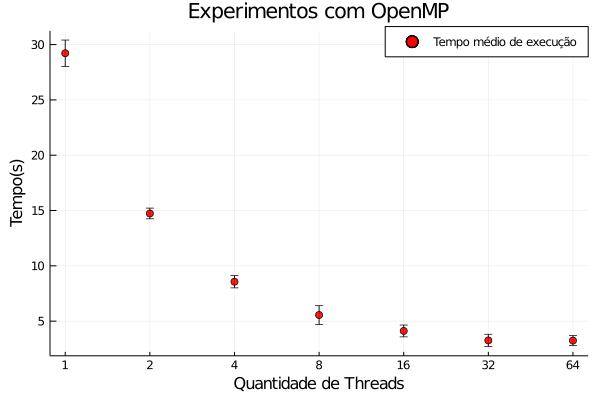

In [36]:
plot_results(final_results_omp.threads, final_results_omp.mean_duration, "Tempo médio de execução", "Quantidade de Threads", "Tempo(s)", "Experimentos com OpenMP", final_results_omp.ci_duration)

Pela mesma argumentação que na versão com p-threads, temos que o valor ideal para o parâmetro é de $64$ threads.

# 7. Comparação entre as diferentes versões

Segue um resumo das escolhas de parâmetros que fizemos (justificadas nas seções acima, junto às apresentações dos resultados):

| Versão | Parâmetro escolhido |
|------|------|
| **CUDA** | bloco de dimensão $(8,8)$ |
| **OMPI** | $64$ processos|
| **OMPI + OMP** | $64$ processos e $8$ threads|
| **OMPI + CUDA** | $x$ processos e blocos de dimensão $(x,x)$|
| **OMP** | $64$ threads |
| **Pthreads** | $32$ threads |

In [37]:
final_results_ompi_omp[46, :]

,threads,processes,mean_duration,ci_duration,processes_string,threads_string
,Int64,String,Float64,Float64,String,String
46,8,65,3.27033,0.188005,65,8


In [38]:
names = ["Sequencial", "OMP", "Pthreads", "OMPI", "CUDA", "OMPI+CUDA", "OMPI+OMP"]

#VALORES DE OMPI_CUDA E OMPI_OMP MOCKADOS
duration = [ final_results_sequencial[1, :mean_duration],
    final_results_omp[7 , :mean_duration],
    final_results_pth[6 , :mean_duration],
    final_results_ompi[7, :mean_duration], 
    final_results_cuda[3, :mean_duration],
    1.0, #OMPI+CUDA
    final_results_ompi_omp[46, :mean_duration],
    ]

ci_d = [ final_results_sequencial[1, :ci_duration],
    final_results_omp[7 , :ci_duration],
    final_results_pth[6 , :ci_duration],
    final_results_ompi[7, :ci_duration],
    final_results_cuda[3, :ci_duration],
    0.0, #OMPI+CUDA
    final_results_ompi_omp[46, :ci_duration],
    ]

7-element Array{Float64,1}:
 1.8240448019133542
 0.44773022801355633
 0.463688214704195
 0.268464012694803
 0.07270052597569586
 0.0
 0.18800486842809855

In [39]:
melhores = DataFrame(nomes = names, duracao= duration, ci = ci_d)


,nomes,duracao,ci
,String,Float64,Float64
1,Sequencial,28.4608,1.82404
2,OMP,3.24436,0.44773
3,Pthreads,3.6455,0.463688
4,OMPI,4.78659,0.268464
5,CUDA,2.27246,0.0727005
6,OMPI+CUDA,1.0,0.0
7,OMPI+OMP,3.27033,0.188005


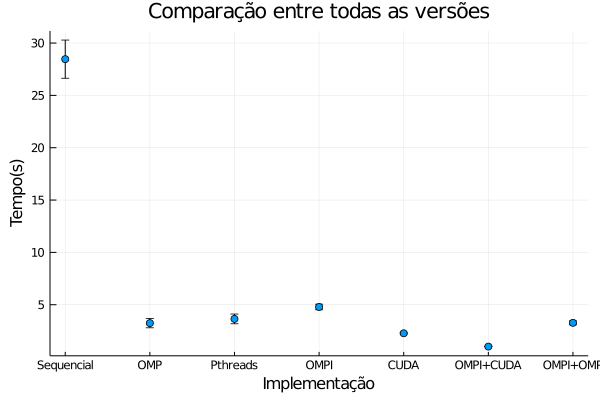

In [40]:
scatter(melhores.nomes, 
        melhores.duracao, 
        yerror = melhores.ci, 
        legend =false,
        ylabel = "Tempo(s)",
        xlabel="Implementação",
        title = "Comparação entre todas as versões")

Temos que todas as versões apresentam um ganho significativo de performance comparando-se com a versão sequencial, o que era esperado. Comparando melhor entre as versões paralelas, temos:

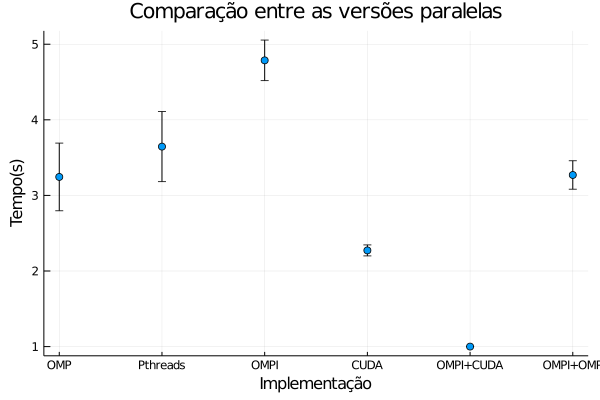

In [41]:
paralelos = melhores[2:7, :]
scatter(paralelos.nomes, 
        paralelos.duracao, 
        yerror = paralelos.ci, 
        legend =false,
        ylabel = "Tempo(s)",
        xlabel="Implementação",
        title = "Comparação entre as versões paralelas")

Podemos perceber que a versão com CUDA possui o melhor desempenho entre todas as implementações, o que se deve a facilidade de adaptação do problema (computação dos valores de pixels de uma imagem) para a computação em uma GPU, que consegue processar milhares de operações simples como as que temos ao mesmo tempo. -Alguma coisa sobre os dois laços serem o gargalo- 

A versão de OMPI teve o pior desempenho entre as versões paralelas, possivelmente devido ao overhead da criação de vários processos ser superior ao overhead da criação de threads que é feita pelos outros métodos. Provavelmente se tivessemos utilizados várias máquinas, que juntas tivessem um poder computacional equivalente, ao invés de apenas uma, os ganhos de desempenho fornecidos pelo OMPI seriam ainda mais significativos. Cabe ressaltar também que essa é a única ferramenta que possibilitaria esse tipo de arquitetura fácilmente.


(Possivelmente inserir OMPI+CUDA abaixo)

Entre as versões que se utilizaram de OMPI, temos que a combinação do OMPI com OMP gerou um pequeno ganho de performance devido a paralelilzação "interna" de cada processo em conjunto com os diversos processos criados. No entanto, a pequena escala do problema provavelmente não possibilitou que os reais ganhos de desempenhos se mostrassem, visto que o _overhead_ começa a se tornar significativo.

Também é interessante ressaltar que a implementação que se utilizou apenas de OMP teve uma performance superior á combinação OMPI+OMP, ressaltando novamente o gargalo do nosso problema.

# 8. Conclusão